In [21]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing



In [22]:
modalities = ["FLAIR", "T1GD", "T1", "T2"]
patient_id='UPENN-GBM-00091_11'

Text(0.5, 1.0, 'Mask')

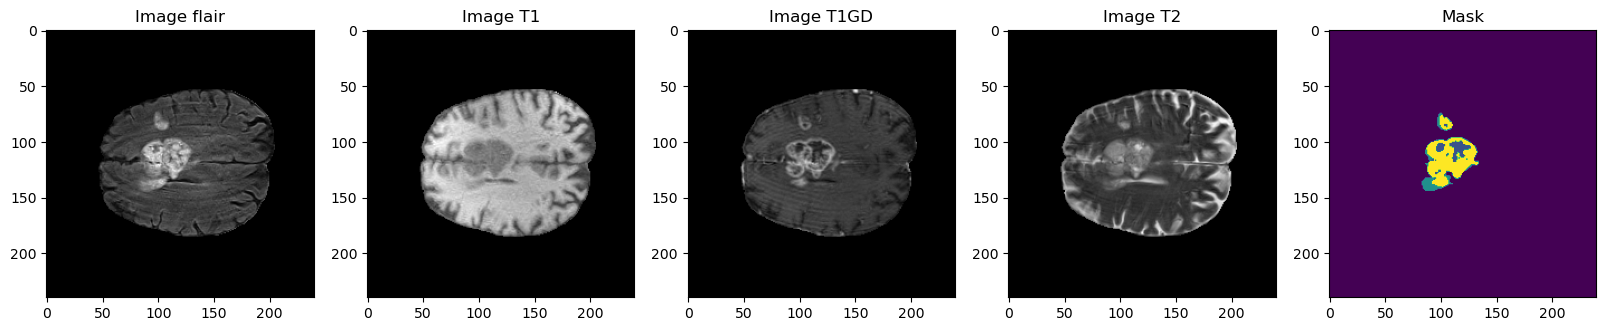

In [23]:
TRAIN_DATASET_PATH ='D:/GBMFeatures/training/'

VALIDATION_DATASET_PATH ='D:/GBMFeatures/validation/'



test_image_flair=nib.load(TRAIN_DATASET_PATH + f'{patient_id}/{patient_id}_FLAIR.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH+f'{patient_id}/{patient_id}_T1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH+f'{patient_id}/{patient_id}_T1GD.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH+f'{patient_id}/{patient_id}_T2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH+f'{patient_id}/{patient_id}_automated_approx_segm.nii.gz').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image T1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image T1GD')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image T2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

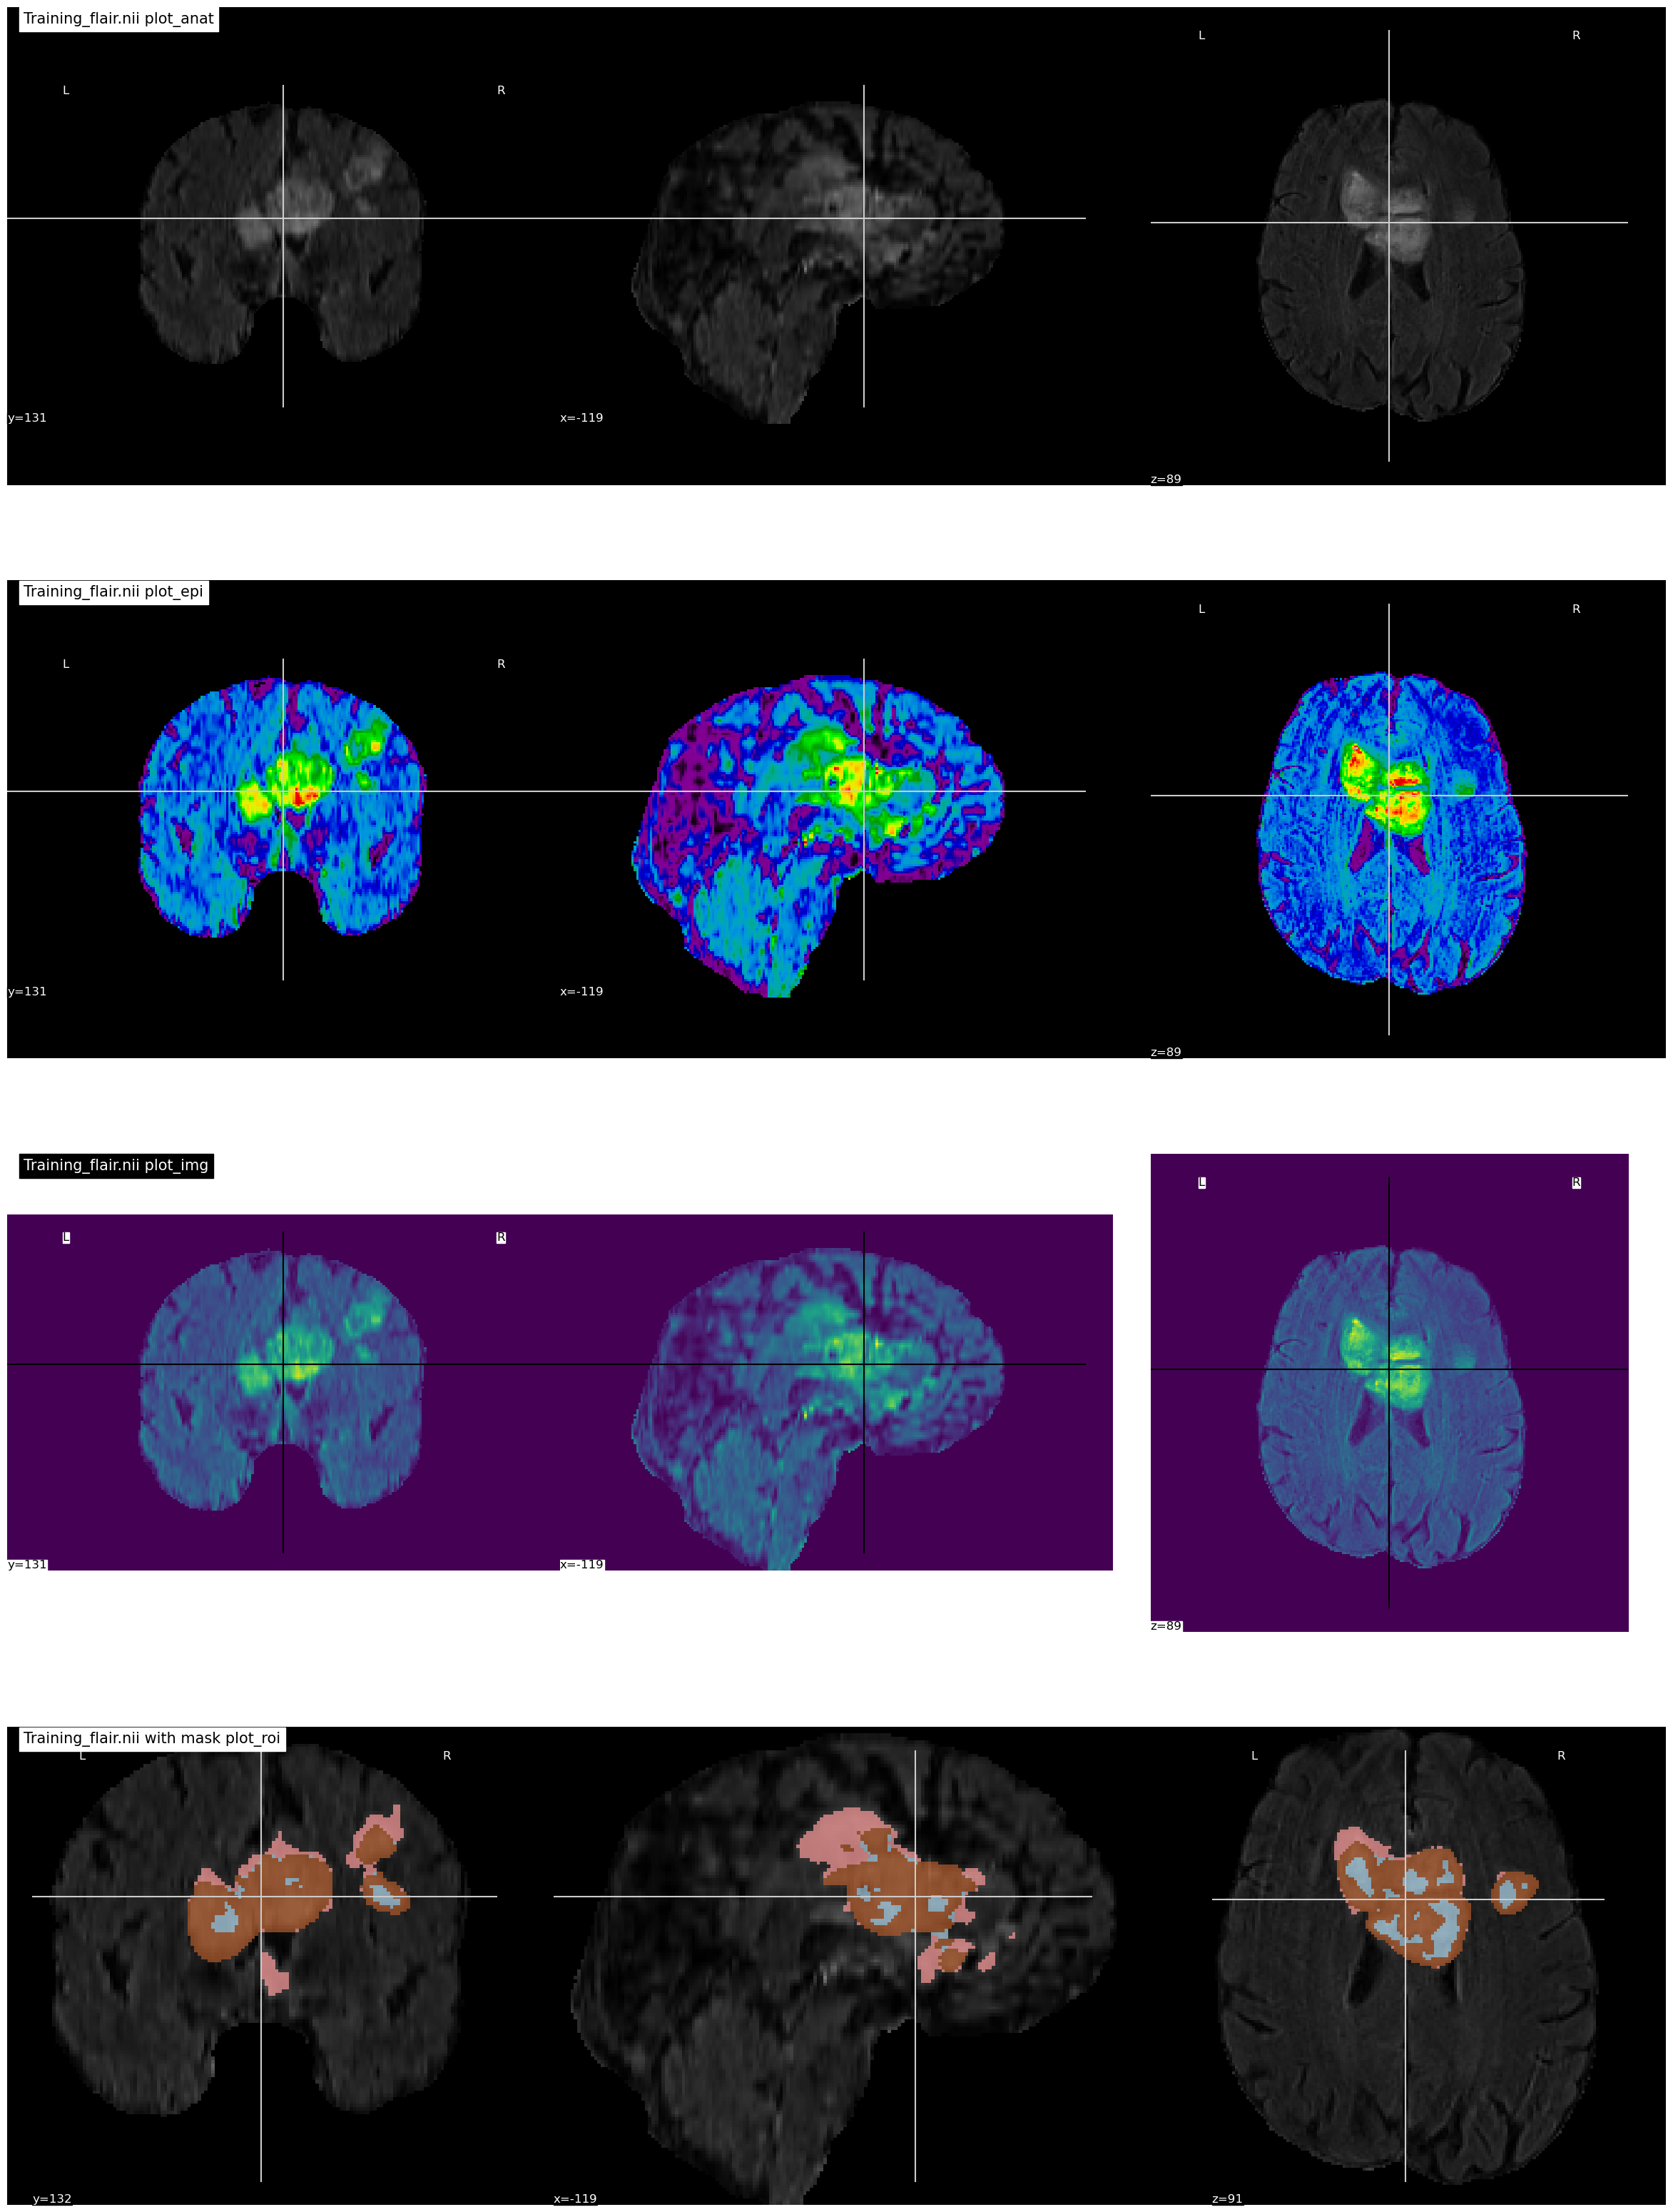

In [24]:
niimg = nl.image.load_img(f'D:/GBMFeatures/training/{patient_id}/{patient_id}_FLAIR.nii.gz')
nimask = nl.image.load_img(f'D:/GBMFeatures/training/{patient_id}/{patient_id}_automated_approx_segm.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='Training_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='Training_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='Training_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='Training_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [5]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'TUMOR' # or NON-ENHANCING tumor CORE
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [6]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
IMG_SIZE=128

In [8]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic] )

In [9]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [11]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, patient_id in enumerate(Batch_ids):
#             case_path = os.path.join(TRAIN_DATASET_PATH, patient_id)

#             data_path = os.path.join(TRAIN_DATASET_PATH,f'{patient_id}/{patient_id}_FLAIR.nii');
            flair = nib.load(TRAIN_DATASET_PATH + f'{patient_id}/{patient_id}_FLAIR.nii.gz').get_fdata()

#             data_path = os.path.join(TRAIN_DATASET_PATH,f'{patient_id}/{patient_id}_T1GD.nii');
            ce = nib.load(TRAIN_DATASET_PATH + f'{patient_id}/{patient_id}_T1GD.nii.gz').get_fdata()
            
#             data_path = os.path.join(TRAIN_DATASET_PATH, f'{patient_id}/{patient_id}_automated_approx_segm.nii');
            seg = nib.load(TRAIN_DATASET_PATH+f'{patient_id}/{patient_id}_automated_approx_segm.nii.gz').get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


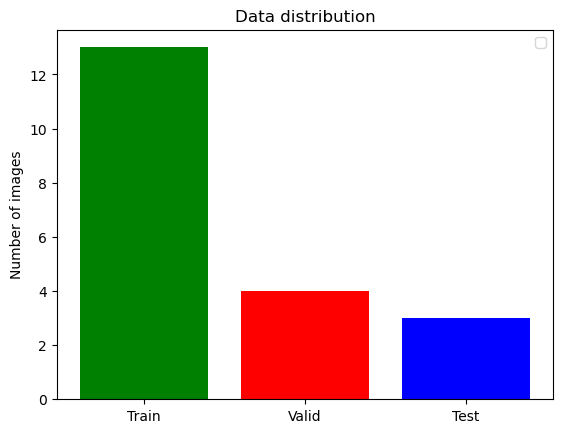

In [12]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [13]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True),
    csv_logger
    ]

In [14]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=12,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  
model.save("model_x1_1.h5")

Epoch 1/12
13/13 [==============================] - 873s 61s/step - loss: 0.7478 - accuracy: 0.8017 - mean_io_u: 0.3827 - dice_coef: 0.3672 - precision: 0.6677 - sensitivity: 0.5763 - specificity: 0.9957 - dice_coef_necrotic: 0.0080 - val_loss: 0.1015 - val_accuracy: 0.9920 - val_mean_io_u: 0.5442 - val_dice_coef: 0.4970 - val_precision: 0.9920 - val_sensitivity: 0.9917 - val_specificity: 0.9973 - val_dice_coef_necrotic: 3.6472e-06 - lr: 0.0010
Epoch 2/12
13/13 [==============================] - 3596s 60s/step - loss: 0.1277 - accuracy: 0.9842 - mean_io_u: 0.4864 - dice_coef: 0.4922 - precision: 0.9840 - sensitivity: 0.9838 - specificity: 0.9947 - dice_coef_necrotic: 0.0158 - val_loss: 0.1186 - val_accuracy: 0.9920 - val_mean_io_u: 0.3756 - val_dice_coef: 0.4807 - val_precision: 0.9916 - val_sensitivity: 0.9917 - val_specificity: 0.9972 - val_dice_coef_necrotic: 0.0612 - lr: 0.0010
Epoch 3/12
13/13 [==============================] - 694s 54s/step - loss: 0.0925 - accuracy: 0.9842 - mea

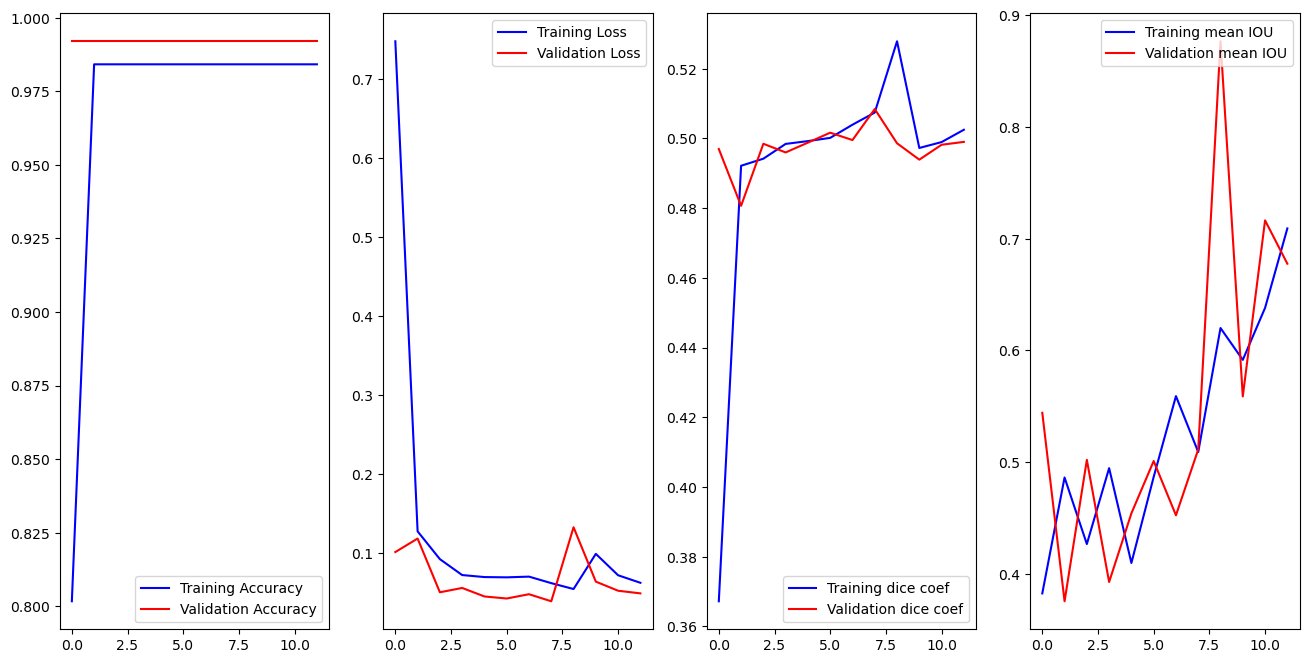

In [16]:
loss=history.history['loss']
val_loss=history.history['val_loss']


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epoch=range(len(acc))
train_dice=history.history['dice_coef']
val_dice=history.history['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,history.history['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,history.history['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

4/4 [==============================] - 10s 2s/step


<Figure size 1800x5000 with 0 Axes>

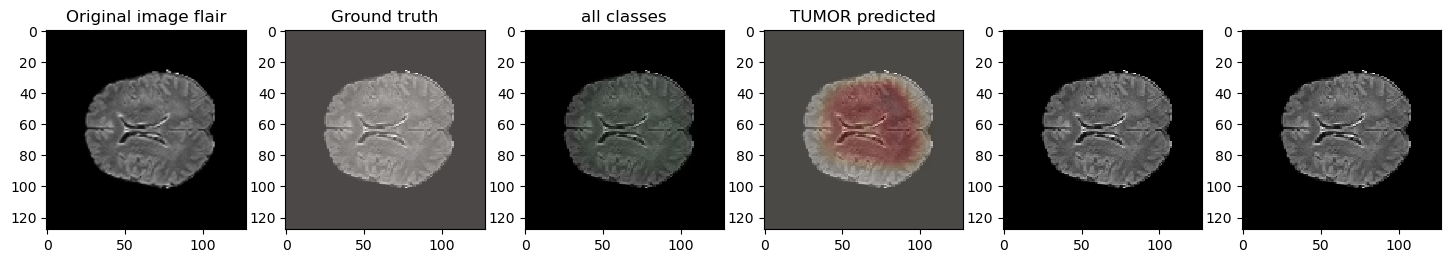

4/4 [==============================] - 10s 2s/step


<Figure size 1800x5000 with 0 Axes>

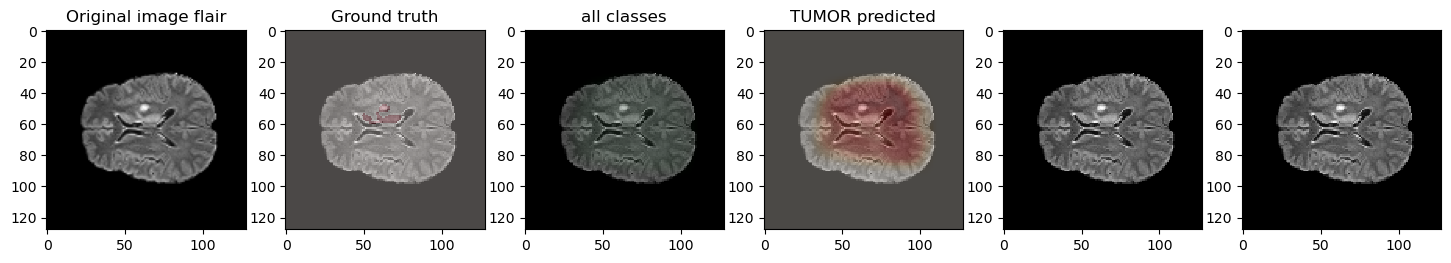

4/4 [==============================] - 10s 2s/step


<Figure size 1800x5000 with 0 Axes>

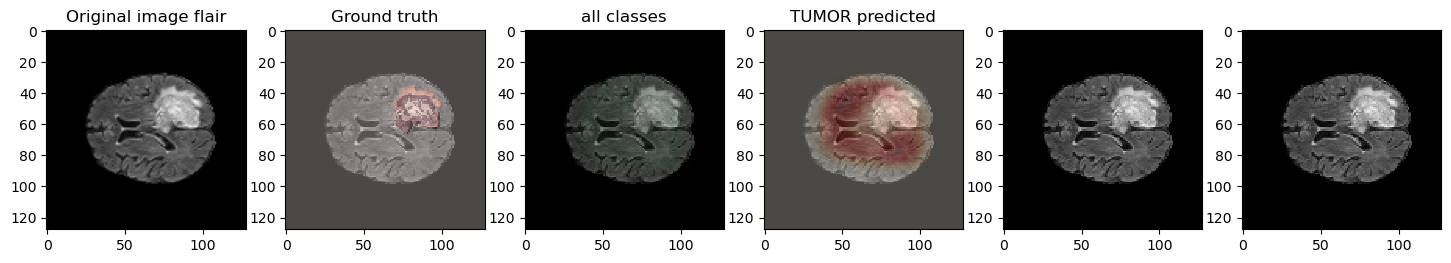

In [17]:
def predictByPath(case_path,patient_id):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
#     vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(case_path + f'{patient_id}_FLAIR.nii.gz').get_fdata()
    
#     vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=flair=nib.load(case_path + f'{patient_id}_T1GD.nii.gz').get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(patient_id, start_slice = 60):
    path=f"D:/GBMFeatures/training/{patient_id}/"
    gt = nib.load(os.path.join(path,f'{patient_id}_automated_approx_segm.nii.gz')).get_fdata()
    origImage = nib.load(os.path.join(path,f'{patient_id}_FLAIR.nii.gz')).get_fdata()
    p = predictByPath(path,patient_id)

    core = p[:,:,:,1]
#     edema= p[:,:,:,2]
#     enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
#     axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
#     axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[3].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
#     axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
#     axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
test_ids=['UPENN-GBM-00134_11','UPENN-GBM-00135_11','UPENN-GBM-00136_11','UPENN-GBM-00138_11','UPENN-GBM-00139_11']          
showPredictsById(test_ids[0])
showPredictsById(test_ids[1])
showPredictsById(test_ids[2])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

4/4 [==============================] - 10s 2s/step


<Figure size 640x480 with 0 Axes>

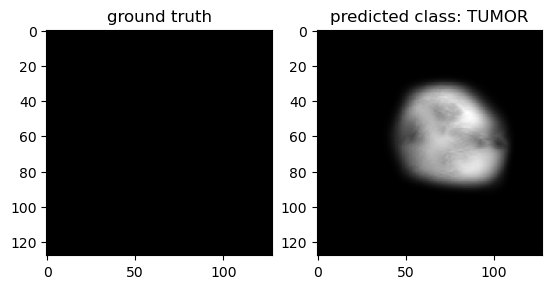

In [18]:
case = test_ids[2]
path=f"D:/GBMFeatures/training/{case}/"
gt = nib.load(os.path.join(path,f'{case}_automated_approx_segm.nii.gz')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]


i=40 # slice at
eval_class = 1 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [19]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=5, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
3/3 [==============================] - 37s 11s/step - loss: 0.0904 - accuracy: 0.9797 - mean_io_u: 0.6644 - dice_coef: 0.4979 - precision: 0.9795 - sensitivity: 0.9796 - specificity: 0.9932 - dice_coef_necrotic: 0.0288
test loss, test acc: [0.09036239981651306, 0.9796624779701233, 0.6643965244293213, 0.4978879392147064, 0.9795100688934326, 0.9795534014701843, 0.9931941032409668, 0.02878481335937977]


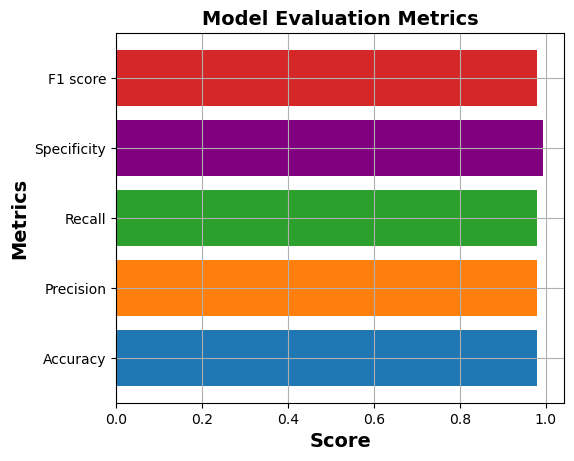

In [20]:
import matplotlib.pyplot as plt
 
# Data
labels = ['Accuracy',  'Precision', 'Recall','Specificity','F1 score',]
values = [0.9797, 0.9795, 0.9796, 0.9932, 0.9792]

# Accuracy: 0.7689
# Precision: 0.6506
# Recall: 0.7297
# Specificity: 0.7899
# F1-Score: 0.6879
    
# Creating axes object
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.2)

# Creating a horizontal bar graph
ax.barh(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c','#800080', '#d62728'])
 
# Setting grid lines
ax.grid(True)
 
# Setting X-axis label
ax.set_xlabel('Score',fontsize=14, fontweight='bold')
 
# Setting Y-axis label
ax.set_ylabel('Metrics',fontsize=14, fontweight='bold')
 
# Title of the plot
ax.set_title('Model Evaluation Metrics',fontsize=14, fontweight='bold')
 
plt.savefig('performance_metrics_mgmt.png')

# Displaying the plot
plt.show()
